In [1]:
%load_ext autoreload
%autoreload 2
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import jax
import numpyro
from numpyro import distributions as dist

import tensorflow as tf
import tensorflow_datasets as t

/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
plt.style.use("seaborn-v0_8")

## Datasets

In [3]:
N = 1000
D = 4
key = jax.random.PRNGKey(seed=0)
with numpyro.plate("data", N):
    x = numpyro.sample("x", dist.Uniform(-10, 10.), rng_key=key)
x = jax.numpy.reshape(x, (-1, 4)) 
key, subkey = jax.random.split(key)
m1, s1 = (dist.Normal(0.0, 2.).sample(key=subkey, sample_shape=(4,)), 
          dist.LogNormal(0.0, 1.0).sample(key=subkey, sample_shape=(x.shape[0],))
        )
key, subkey = jax.random.split(key)
u = numpyro.sample("u", dist.Normal(x@m1, s1), rng_key=subkey)

In [4]:
x = tf.convert_to_tensor(x)
y = tf.convert_to_tensor(u)

In [5]:
x.shape, y.shape

(TensorShape([250, 4]), TensorShape([250]))

In [6]:
y = tf.reshape(y, (-1, 1))

In [7]:
x = x - tf.math.reduce_mean(x, 0, keepdims=True) 
x /= tf.math.reduce_std(x, 0, keepdims=True)

In [8]:
tf.math.reduce_mean(x, 0), tf.math.reduce_std(x, 0)

(<tf.Tensor: shape=(4,), dtype=float32, numpy=
 array([ 1.3351441e-08, -1.4901161e-08,  1.0490417e-08, -1.5497207e-08],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.99999994, 1.        , 1.0000001 , 0.99999994], dtype=float32)>)

In [9]:
class Linear(tf.Module):
    
    def __init__(self, in_feat, out_feat, name=None, activation="identity"):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_feat, out_feat]) * 2 / np.sqrt(in_feat), name="w")
        self.b = tf.Variable(tf.zeros([out_feat]), name="b")
        self.activation = {"identity": tf.identity, "relu": tf.nn.relu, "selu": tf.nn.selu,
                                     "gelu": tf.nn.gelu, "silu": tf.nn.silu }[activation]
    def __call__(self, x):
        x = tf.matmul(x, self.w) + self.b
        return self.activation(x)
    

In [10]:
class RegModule(tf.Module):
    def __init__(self, in_feat, hidden1, name=None):
        super().__init__(name=name)
        self.lin1 = Linear(in_feat, hidden1, activation="relu")
        self.lin2 = Linear(hidden1, 1)
    
    def __call__(self, x):
        x = self.lin1(x)
        x = self.lin2(x)
        return x
        

In [11]:
net = RegModule(D, 8)

In [12]:
net.submodules

(<__main__.Linear at 0x7fa7d00cf8b0>, <__main__.Linear at 0x7fa7d00cf2e0>)

In [13]:
net.variables

(<tf.Variable 'b:0' shape=(8,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'w:0' shape=(4, 8) dtype=float32, numpy=
 array([[ 0.05343907, -0.64620936,  0.0104877 ,  0.73585206,  0.7280023 ,
          1.655985  , -0.8846577 , -0.29938447],
        [ 0.10300572,  1.9017677 , -0.39868727,  1.408137  , -0.05627052,
         -0.17337033, -2.2921865 ,  0.33579674],
        [ 0.43652046,  0.83627015, -0.36177674,  0.1234626 ,  0.1032427 ,
         -1.5055033 , -1.7950017 , -0.87967366],
        [-0.41618684,  0.33824092, -1.3792052 , -0.3136401 , -0.66273975,
          1.570117  ,  0.5295412 , -0.9044974 ]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'w:0' shape=(8, 1) dtype=float32, numpy=
 array([[-0.2902276 ],
        [-0.40673855],
        [ 0.6245968 ],
        [-0.7665438 ],
        [-0.26995853],
        [ 0.5910276 ],
        [ 1.6859132 ],
        [ 0.54694414]], dtype

In [14]:
net.trainable_variables

(<tf.Variable 'b:0' shape=(8,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'w:0' shape=(4, 8) dtype=float32, numpy=
 array([[ 0.05343907, -0.64620936,  0.0104877 ,  0.73585206,  0.7280023 ,
          1.655985  , -0.8846577 , -0.29938447],
        [ 0.10300572,  1.9017677 , -0.39868727,  1.408137  , -0.05627052,
         -0.17337033, -2.2921865 ,  0.33579674],
        [ 0.43652046,  0.83627015, -0.36177674,  0.1234626 ,  0.1032427 ,
         -1.5055033 , -1.7950017 , -0.87967366],
        [-0.41618684,  0.33824092, -1.3792052 , -0.3136401 , -0.66273975,
          1.570117  ,  0.5295412 , -0.9044974 ]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'w:0' shape=(8, 1) dtype=float32, numpy=
 array([[-0.2902276 ],
        [-0.40673855],
        [ 0.6245968 ],
        [-0.7665438 ],
        [-0.26995853],
        [ 0.5910276 ],
        [ 1.6859132 ],
        [ 0.54694414]], dtype

In [15]:
net.lin1.non_trainable_variables

()

In [16]:
del net.lin1

In [17]:
net.trainable_variables

(<tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'w:0' shape=(8, 1) dtype=float32, numpy=
 array([[-0.2902276 ],
        [-0.40673855],
        [ 0.6245968 ],
        [-0.7665438 ],
        [-0.26995853],
        [ 0.5910276 ],
        [ 1.6859132 ],
        [ 0.54694414]], dtype=float32)>)

In [18]:
net.non_trainable_variables

()

In [19]:
net.lin2.trainable = False

In [20]:
net.non_trainable_variables

()

In [21]:
net.trainable_variables

(<tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'w:0' shape=(8, 1) dtype=float32, numpy=
 array([[-0.2902276 ],
        [-0.40673855],
        [ 0.6245968 ],
        [-0.7665438 ],
        [-0.26995853],
        [ 0.5910276 ],
        [ 1.6859132 ],
        [ 0.54694414]], dtype=float32)>)

In [22]:
net.lin2.w = tf.Variable(net.lin2.w.numpy(), False)

In [23]:
net.trainable_variables

(<tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,)

In [24]:
net.non_trainable_variables

(<tf.Variable 'Variable:0' shape=(8, 1) dtype=float32, numpy=
 array([[-0.2902276 ],
        [-0.40673855],
        [ 0.6245968 ],
        [-0.7665438 ],
        [-0.26995853],
        [ 0.5910276 ],
        [ 1.6859132 ],
        [ 0.54694414]], dtype=float32)>,)

In [25]:

@tf.function
def train(dataset: tf.data.Dataset, model: RegModule, lr: tf.Tensor, epochs: tf.Tensor, step: tf.Variable):
    losses = tf.TensorArray(dtype=tf.float32, dynamic_size=True, size=0)
    for i in range(epochs):
        for (x, y) in dataset:
            with tf.GradientTape() as tape:
                yhat = model(x)
                loss = tf.math.reduce_mean((y - yhat) ** 2)
                tf.print(loss)
                losses = losses.write(step, loss)
                step.assign_add(1)
            grads = tape.gradient(loss, model.trainable_variables)
            for w, g in zip(model.trainable_variables,grads):
                w.assign_add( -lr * g)
    return losses.stack()
                
        

In [26]:
ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(50)

In [27]:
for a, b in ds:
    print(a.shape, b.shape)

(50, 4) (50, 1)
(50, 4) (50, 1)
(50, 4) (50, 1)
(50, 4) (50, 1)
(50, 4) (50, 1)


In [28]:
a[:10]

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[-0.6520352 ,  1.1371522 ,  0.6709285 , -0.51386076],
       [ 1.2721881 ,  0.825287  , -0.13445333, -1.7060719 ],
       [-1.1639551 ,  1.5367683 ,  0.4913037 , -0.79017437],
       [ 0.41745436, -0.7206475 , -1.4956665 , -1.3537912 ],
       [ 0.90091   , -1.0873332 ,  1.0437733 ,  0.89761996],
       [-1.1482003 ,  1.1092883 ,  0.9408407 ,  0.86482996],
       [ 0.49455872, -0.57093465, -0.7048087 ,  1.7270492 ],
       [-0.55817175,  0.02904524, -0.53178674,  0.9006861 ],
       [-1.4399315 ,  0.75760365, -0.09381334,  0.9300494 ],
       [ 0.99490595, -0.27438605,  0.32521307, -0.21980123]],
      dtype=float32)>

In [29]:
tf.random.set_seed(0)
net = RegModule(D, 8)

In [30]:
tf.reduce_mean(net.lin1.w), net.lin1.w

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.032753866>,
 <tf.Variable 'w:0' shape=(4, 8) dtype=float32, numpy=
 array([[ 1.5110626 ,  0.42292207, -0.41969493, -1.0360373 , -1.2368279 ,
          0.47027302, -0.01397488,  1.1888583 ],
        [ 0.60253334,  0.5997111 , -0.70571196, -0.43297547,  0.7936245 ,
         -0.6974926 , -0.95983326, -0.9006969 ],
        [-0.36081055, -0.22377317,  0.30383846,  0.52152544,  0.1554326 ,
          1.5885501 , -0.7958055 ,  0.07794423],
        [-0.17937538, -0.85996604,  0.21930954,  0.71412295, -2.4445748 ,
          0.0267799 ,  1.7339767 , -0.71103793]], dtype=float32)>)

In [31]:
lr =  tf.constant(1e-3)
epochs = tf.constant(20)
step = tf.Variable(0, trainable=False, name="step")
l = train(ds, net, lr, epochs, step)
tf.reduce_mean(net.lin1.w)

374.888763
261.372101
311.728607
271.153931
339.108673
345.578278
240.642
286.142395
248.28363
313.03952
318.109955
221.08342
262.453979
225.954498
288.131165
290.993256
202.066559
239.626373
203.548706
263.512695
264.330658
183.005219
217.265823
181.282974
238.919632
237.588074
164.016312
195.138977
159.131882
213.820587
210.423401
144.974258
172.300842
137.127304
188.426605
183.384979
126.004837
149.715942
116.040314
163.804321
157.474533
107.916328
127.809402
96.1406
140.131012
132.961136
90.726181
107.192619
78.2015
117.903107
110.465729
75.3919067
88.8418961
62.5527
97.95681
90.6571884
62.2859
72.9564667
49.3840218
80.6643372
73.6771851
51.4844093
59.5800591
38.7287788
66.102005
59.576149
42.9041595
48.6795502
30.4122849
54.115551
48.1666069
36.3077736
40.0057373
24.1200485
44.486908
39.1364861
31.3677864
33.2388344
19.4895477
36.8828392
32.060009
27.6830101
28.0438519
16.1960011
30.9865665
26.6550846
25.0664444
24.1205273
13.9060202
26.4735126
22.5576344
23.2381973
21.1721191
12.

<tf.Tensor: shape=(), dtype=float32, numpy=-0.029592436>

In [32]:
l

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([374.88876 , 261.3721  , 311.7286  , 271.15393 , 339.10867 ,
       345.57828 , 240.642   , 286.1424  , 248.28363 , 313.03952 ,
       318.10995 , 221.08342 , 262.45398 , 225.9545  , 288.13116 ,
       290.99326 , 202.06656 , 239.62637 , 203.5487  , 263.5127  ,
       264.33066 , 183.00522 , 217.26582 , 181.28297 , 238.91963 ,
       237.58807 , 164.01631 , 195.13898 , 159.13188 , 213.82059 ,
       210.4234  , 144.97426 , 172.30084 , 137.1273  , 188.4266  ,
       183.38498 , 126.00484 , 149.71594 , 116.04031 , 163.80432 ,
       157.47453 , 107.91633 , 127.8094  ,  96.1406  , 140.13101 ,
       132.96114 ,  90.72618 , 107.19262 ,  78.2015  , 117.90311 ,
       110.46573 ,  75.39191 ,  88.841896,  62.5527  ,  97.95681 ,
        90.65719 ,  62.2859  ,  72.95647 ,  49.38402 ,  80.66434 ,
        73.677185,  51.48441 ,  59.58006 ,  38.72878 ,  66.102005,
        59.57615 ,  42.90416 ,  48.67955 ,  30.412285,  54.11555 ,
        48.166

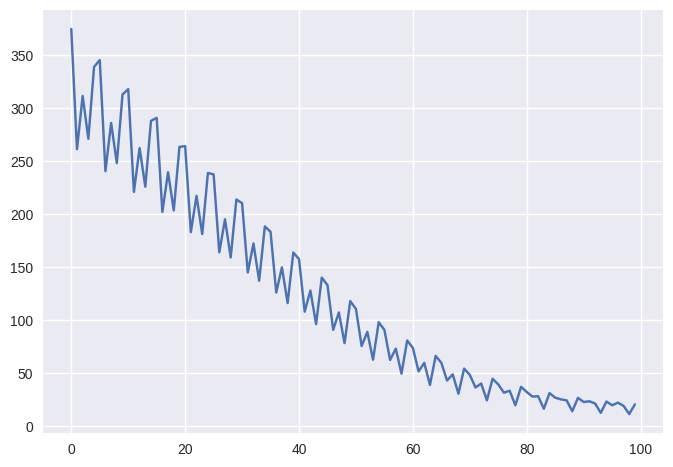

In [33]:
plt.plot(l)

In [34]:
path = "/mnt/dl/tensorflow_training/dummy1"
model_path = path +  "/model"
ckpt = tf.train.Checkpoint(model=net)
ckpt.save(model_path)

'/mnt/dl/tensorflow_training/dummy1/model-1'

In [35]:
os.listdir(path)

['checkpoint', 'model-1.index', 'model-1.data-00000-of-00001']

In [36]:
net(a)[10]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-31.630892], dtype=float32)>

In [37]:
new_net =  RegModule(D, 8)

In [38]:
new_net(a)[10]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.55888295], dtype=float32)>

In [39]:
ckpt = tf.train.Checkpoint(model=new_net)

In [40]:
ckpt.restore(path +  "/model-1")

In [41]:
new_net(a)[10]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-31.630892], dtype=float32)>

In [42]:
path = "/mnt/dl/tensorflow_training/dummy11"
model_path = path +  "/model"
saved = tf.saved_model.save(net, path)

INFO:tensorflow:Assets written to: /mnt/dl/tensorflow_training/dummy11/assets


In [43]:
new_net2 = tf.saved_model.load(path)

In [45]:
new_net2

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fa6f860b760>